<a href="https://colab.research.google.com/github/diowahyu/11diowahyu.git.io/blob/main/implementasi_data_harga_saham_menggunakan_RNN_murni.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

A. preprocessing data

1. Pembersihan data

In [ ]:
import pandas as pd
import numpy as np

# Load the dataset
try:
    df = pd.read_csv('/content/stock_price.csv')
except FileNotFoundError:
    print("Error: File not found. Please make sure '/content/stock_price.csv' exists.")
    exit()


# 1. Handling Missing Values
# Replace missing values with the mean for numerical columns
for col in df.select_dtypes(include=np.number):
    if df[col].isnull().any():
        df[col].fillna(df[col].mean(), inplace=True)

# Replace missing values with the mode for categorical columns (if any exist)
for col in df.select_dtypes(include='object'):  # Check object (string) columns
    if df[col].isnull().any():
        df[col].fillna(df[col].mode()[0], inplace=True)


# 2. Removing Duplicates
df.drop_duplicates(inplace=True)


# 3. Data Transformation (Example: Convert date column to datetime)
# Assuming you have a column named 'Date' representing dates.
# Adapt this part to the actual name of your date column.
if 'Date' in df.columns:
  try:
      df['Date'] = pd.to_datetime(df['Date'])
  except ValueError:
      print("Error converting 'Date' column to datetime. Check the format.")
      # You might need to handle date formats differently here
      # based on the actual format in your CSV.
      # For example:
      # df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')
      pass


# 4. Outlier Handling (Example: IQR method for numerical columns)
def remove_outliers_iqr(df, column):
  Q1 = df[column].quantile(0.25)
  Q3 = df[column].quantile(0.75)
  IQR = Q3 - Q1
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR
  df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
  return df

# Apply IQR method (adjust column names as needed)
# Example: for column 'Close'
if 'Close' in df.columns:
  df = remove_outliers_iqr(df, 'Close')


# 5. Feature Scaling (Example: MinMaxScaler)
# Import MinMaxScaler from sklearn.preprocessing
from sklearn.preprocessing import MinMaxScaler

# Assuming you want to scale 'Close' price
if 'Close' in df.columns:
    scaler = MinMaxScaler()
    df[['Close']] = scaler.fit_transform(df[['Close']])


# Display the first few rows of the cleaned dataset
print(df.head())

# Save the cleaned dataframe (optional)
df.to_csv('/content/cleaned_stock_price.csv', index=False)

                           Date    Open    High     Low     Close     Volume  \
0 1970-01-01 00:00:00.020240130  5525.0  5650.0  5475.0  0.668803  150287800   
1 1970-01-01 00:00:00.020240131  5725.0  5775.0  5675.0  0.700855  245117200   
2 1970-01-01 00:00:00.020240201  5775.0  5800.0  5725.0  0.722222  156634200   
3 1970-01-01 00:00:00.020240202  5800.0  5850.0  5750.0  0.764957  177209700   
4 1970-01-01 00:00:00.020240205  5800.0  5825.0  5750.0  0.732906  113760000   

   AdjustedClose  
0         5625.0  
1         5700.0  
2         5750.0  
3         5850.0  
4         5775.0  


2. Seleksi fitur

In [ ]:
import pandas as pd
from sklearn.feature_selection import SelectKBest, f_regression

# Load the cleaned dataset
try:
    df = pd.read_csv('/content/cleaned_stock_price.csv')
except FileNotFoundError:
    print("Error: File not found. Please make sure '/content/cleaned_stock_price.csv' exists.")
    exit()

# Assuming 'Close' is your target variable
# Identify numerical features for feature selection
numerical_features = df.select_dtypes(include=['number']).columns
numerical_features = numerical_features.drop('Close') # Exclude the target variable

# Separate features (X) and target (y)
X = df[numerical_features]
y = df['Close']

# Select top k features using ANOVA F-value (f_regression)
# Adjust k (number of features to select) as needed
k = 3 # Example: select top 3 features
selector = SelectKBest(score_func=f_regression, k=k)
X_new = selector.fit_transform(X, y)

# Get the names of selected features
selected_feature_indices = selector.get_support(indices=True)
selected_features = list(numerical_features[selected_feature_indices])

# Print the selected features
print("Selected Features:", selected_features)

# Create a new DataFrame with selected features and the target variable
selected_df = df[selected_features + ['Close']]

# Display the first few rows of the dataframe with selected features
print(selected_df.head())

# Save the dataframe with selected features (optional)
selected_df.to_csv('/content/selected_features.csv', index=False)

Selected Features: ['High', 'Low', 'AdjustedClose']
     High     Low  AdjustedClose     Close
0  5650.0  5475.0         5625.0  0.668803
1  5775.0  5675.0         5700.0  0.700855
2  5800.0  5725.0         5750.0  0.722222
3  5850.0  5750.0         5850.0  0.764957
4  5825.0  5750.0         5775.0  0.732906


3. Normalisasi data

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Load the dataset with selected features
try:
    df = pd.read_csv('/content/selected_features.csv')
except FileNotFoundError:
    print("Error: File not found. Please make sure '/content/selected_features.csv' exists.")
    exit()

# Identify numerical features to normalize (exclude 'Close' if it's the target)
numerical_features = df.select_dtypes(include=['number']).columns
if 'Close' in numerical_features:
    numerical_features = numerical_features.drop('Close')

# Normalize the selected numerical features using MinMaxScaler
scaler = MinMaxScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])

# Display the first few rows of the normalized dataset
print(df.head())

# Save the normalized dataset (optional)
df.to_csv('/content/normalized_selected_features.csv', index=False)

       High       Low  AdjustedClose     Close
0  0.658120  0.619565       0.668803  0.668803
1  0.711538  0.706522       0.700855  0.700855
2  0.722222  0.728261       0.722222  0.722222
3  0.743590  0.739130       0.764957  0.764957
4  0.732906  0.739130       0.732906  0.732906


4. sekuensi data

In [ ]:
import pandas as pd

# Load the normalized dataset
try:
    df = pd.read_csv('/content/normalized_selected_features.csv')
except FileNotFoundError:
    print("Error: File not found. Please make sure '/content/normalized_selected_features.csv' exists.")
    exit()

# Assuming you want to create a sequence of data with a window size of 3
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data)-seq_length-1):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Example usage with window size of 3
seq_length = 3
data = df.values # Convert the DataFrame to a NumPy array

# Create sequences
X, y = create_sequences(data, seq_length)

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

# Example: Print first 5 sequences
for i in range(5):
    print("Sequence",i+1,":\nX:", X[i], "\ny:", y[i])

Shape of X: (213, 3, 4)
Shape of y: (213, 4)
Sequence 1 :
X: [[0.65811966 0.61956522 0.66880342 0.66880342]
 [0.71153846 0.70652174 0.7008547  0.7008547 ]
 [0.72222222 0.72826087 0.72222222 0.72222222]] 
y: [0.74358974 0.73913043 0.76495726 0.76495726]
Sequence 2 :
X: [[0.71153846 0.70652174 0.7008547  0.7008547 ]
 [0.72222222 0.72826087 0.72222222 0.72222222]
 [0.74358974 0.73913043 0.76495726 0.76495726]] 
y: [0.73290598 0.73913043 0.73290598 0.73290598]
Sequence 3 :
X: [[0.72222222 0.72826087 0.72222222 0.72222222]
 [0.74358974 0.73913043 0.76495726 0.76495726]
 [0.73290598 0.73913043 0.73290598 0.73290598]] 
y: [0.76495726 0.76086957 0.7542735  0.7542735 ]
Sequence 4 :
X: [[0.74358974 0.73913043 0.76495726 0.76495726]
 [0.73290598 0.73913043 0.73290598 0.73290598]
 [0.76495726 0.76086957 0.7542735  0.7542735 ]] 
y: [0.76495726 0.77173913 0.76495726 0.76495726]
Sequence 5 :
X: [[0.73290598 0.73913043 0.73290598 0.73290598]
 [0.76495726 0.76086957 0.7542735  0.7542735 ]
 [0.76495726 

5. pembagian data

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Load the preprocessed dataset
try:
    df = pd.read_csv('/content/normalized_selected_features.csv')
except FileNotFoundError:
    print("Error: File not found. Please make sure '/content/normalized_selected_features.csv' exists.")
    exit()

# Assuming 'Close' is your target variable
X = df.drop('Close', axis=1)
y = df['Close']

# Split the data into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, shuffle=False)  # Use shuffle=False to maintain time series order
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

# Print the shapes of the resulting datasets
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

#You can now use X_train, y_train, X_val, y_val, X_test, y_test for model training and evaluation

X_train shape: (151, 3)
y_train shape: (151,)
X_val shape: (33, 3)
y_val shape: (33,)
X_test shape: (33, 3)
y_test shape: (33,)


6. Cek korelasi data

                   High       Low  AdjustedClose     Close
High           1.000000  0.996943       0.996769  0.996769
Low            0.996943  1.000000       0.997119  0.997119
AdjustedClose  0.996769  0.997119       1.000000  1.000000
Close          0.996769  0.997119       1.000000  1.000000


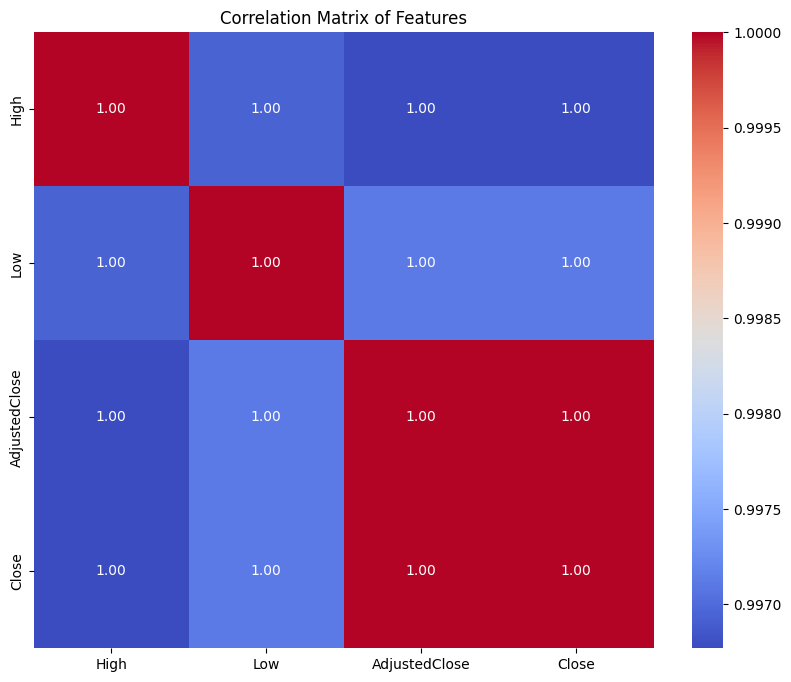

In [ ]:
import pandas as pd

# Load the preprocessed dataset
try:
    df = pd.read_csv('/content/normalized_selected_features.csv')
except FileNotFoundError:
    print("Error: File not found. Please make sure '/content/normalized_selected_features.csv' exists.")
    exit()

# Calculate the correlation matrix
correlation_matrix = df.corr()

# Print the correlation matrix
print(correlation_matrix)

# You can also visualize the correlation matrix using a heatmap (optional)
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Features')
plt.show()

B. RNN Model Development

1. Membuat model RNN

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from sklearn.metrics import mean_squared_error

# Load the preprocessed dataset
try:
    df = pd.read_csv('/content/normalized_selected_features.csv')
except FileNotFoundError:
    print("Error: File not found. Please make sure '/content/normalized_selected_features.csv' exists.")
    exit()

# Prepare the data for RNN
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data)-seq_length-1):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length, -1] # Assuming the last column is the target variable
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 10  # Adjust sequence length as needed
data = df.values
X, y = create_sequences(data, seq_length)

# Split data into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)


# Reshape the input data for SimpleRNN (samples, timesteps, features)
X_train = X_train.reshape(X_train.shape[0], seq_length, X_train.shape[2])
X_val = X_val.reshape(X_val.shape[0], seq_length, X_val.shape[2])
X_test = X_test.reshape(X_test.shape[0], seq_length, X_test.shape[2])


# Define the RNN model
model = Sequential()
model.add(SimpleRNN(50, activation='relu', input_shape=(seq_length, X_train.shape[2])))
model.add(Dense(1))  # Output layer with one neuron for regression

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val))

# Evaluate the model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error on test data: {mse}')

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.2680 - val_loss: 0.0027
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0147 - val_loss: 0.0290
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0294 - val_loss: 0.0044
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0068 - val_loss: 0.0014
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0084 - val_loss: 0.0042
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0049 - val_loss: 0.0056
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0065 - val_loss: 0.0037
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0051 - val_loss: 0.0019
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0044 - val_loss: 0.0021
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0042 - val_loss: 0.0024
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0041 - val_loss: 0.0017
Epoch 12/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0031 - val_loss: 0.0019
Epoch 13/50
6/6 ━━━━━

2. Pelatihan Model

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from sklearn.metrics import mean_squared_error

# Load the preprocessed dataset
try:
    df = pd.read_csv('/content/normalized_selected_features.csv')
except FileNotFoundError:
    print("Error: File not found. Please make sure '/content/normalized_selected_features.csv' exists.")
    exit()

# Prepare the data for RNN
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data)-seq_length-1):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length, -1]  # Assuming the last column is the target variable
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 10  # Adjust sequence length as needed
data = df.values
X, y = create_sequences(data, seq_length)

# Split data into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

# Reshape the input data for SimpleRNN (samples, timesteps, features)
X_train = X_train.reshape(X_train.shape[0], seq_length, X_train.shape[2])
X_val = X_val.reshape(X_val.shape[0], seq_length, X_val.shape[2])
X_test = X_test.reshape(X_test.shape[0], seq_length, X_test.shape[2])

# Define the RNN model
model = Sequential()
model.add(SimpleRNN(50, activation='relu', input_shape=(seq_length, X_train.shape[2])))
model.add(Dense(1))  # Output layer with one neuron for regression

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val))

# Evaluate the model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error on test data: {mse}')

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.3349 - val_loss: 0.0018
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0170 - val_loss: 0.0261
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0374 - val_loss: 0.0085
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0076 - val_loss: 0.0018
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0103 - val_loss: 0.0018
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0084 - val_loss: 0.0033
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0051 - val_loss: 0.0040
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0054 - val_loss: 0.0023
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0041 - val_loss: 0.0022
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0043 - val_loss: 0.0030
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0046 - val_loss: 0.0019
Epoch 12/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0048 - val_loss: 0.0025
Epoch 13/50
6/6 ━━━━━

3. Evaluasi model

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense

try:
    df = pd.read_csv('/content/normalized_selected_features.csv')
except FileNotFoundError:
    print("Error: File not found. Please make sure '/content/normalized_selected_features.csv' exists.")
    exit()

# Prepare the data for RNN
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data)-seq_length-1):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length, -1]  # Assuming the last column is the target variable
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 10  # Adjust sequence length as needed
data = df.values
X, y = create_sequences(data, seq_length)

# Split data into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

# Reshape the input data for SimpleRNN (samples, timesteps, features)
X_train = X_train.reshape(X_train.shape[0], seq_length, X_train.shape[2])
X_val = X_val.reshape(X_val.shape[0], seq_length, X_val.shape[2])
X_test = X_test.reshape(X_test.shape[0], seq_length, X_test.shape[2])

# ... (rest of your model training code from the previous response)

# Evaluate the model
y_pred = model.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'R-squared (R2): {r2}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Mean Squared Error (MSE): 0.00201370414198733
Root Mean Squared Error (RMSE): 0.04487431494727613
Mean Absolute Error (MAE): 0.03733270299364314
R-squared (R2): -0.0967545864175452


4. Prediksi dan visualisasi

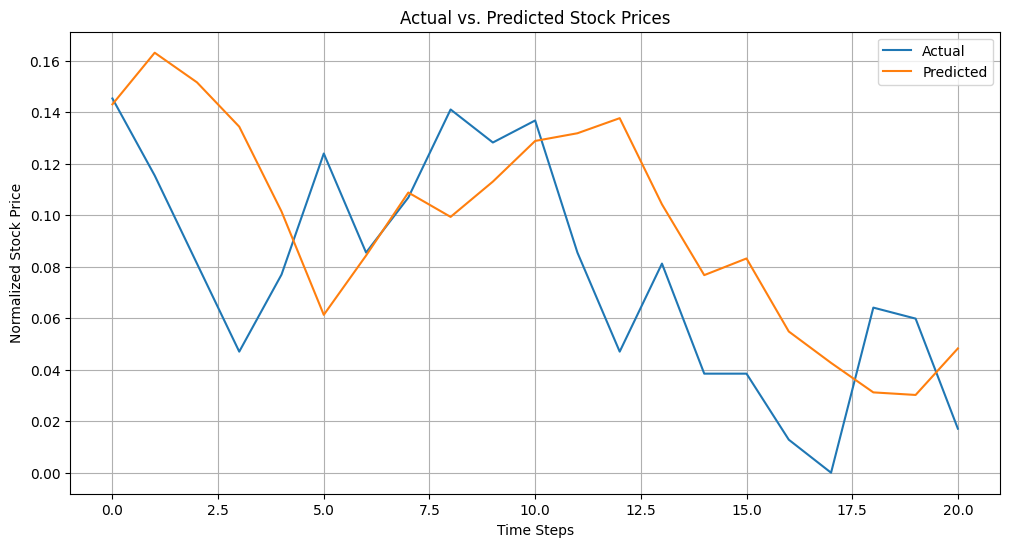

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'y_test' and 'y_pred' are available from your model evaluation

# Plot the actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.xlabel('Time Steps')
plt.ylabel('Normalized Stock Price')
plt.title('Actual vs. Predicted Stock Prices')
plt.legend()
plt.grid(True)
plt.show()

5. Fine-Tuning Model

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.1323 - val_loss: 0.0026
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0151 - val_loss: 0.0053
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0079 - val_loss: 0.0097
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0113 - val_loss: 0.0045
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0033 - val_loss: 0.0015
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0034 - val_loss: 0.0012
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0035 - val_loss: 0.0018
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0026 - val_loss: 0.0028
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0027 - val_loss: 0.0029
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0026 - val_loss: 0.0022
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0027 - val_loss: 0.0014
Epoch 12/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0030 - val_loss: 0.0014
Epoch 13/50
6/6 ━━━━

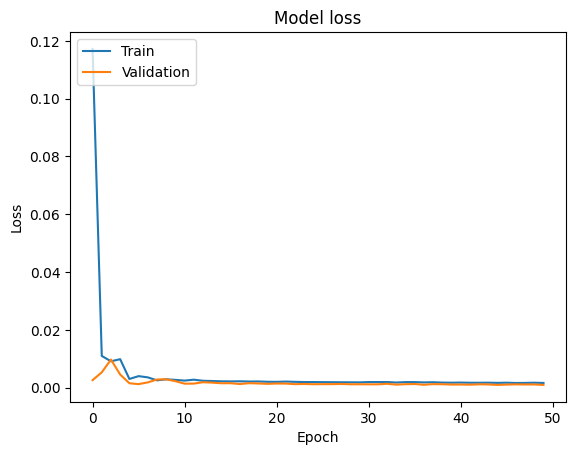

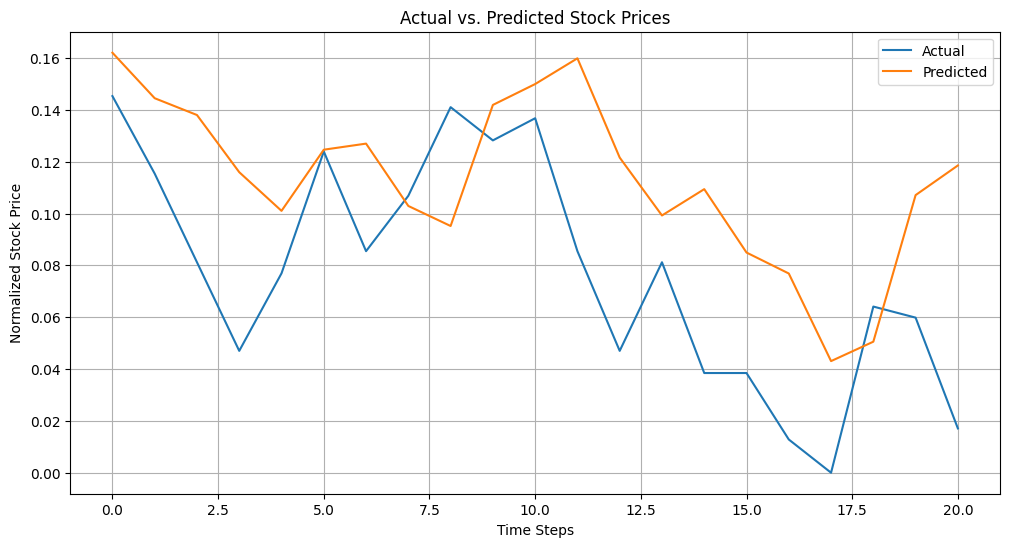

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Load the preprocessed dataset
try:
    df = pd.read_csv('/content/normalized_selected_features.csv')
except FileNotFoundError:
    print("Error: File not found. Please make sure '/content/normalized_selected_features.csv' exists.")
    exit()

# Prepare the data for RNN
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data)-seq_length-1):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length, -1]  # Assuming the last column is the target variable
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 10  # Adjust sequence length as needed
data = df.values
X, y = create_sequences(data, seq_length)

# Split data into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

# Reshape the input data for SimpleRNN (samples, timesteps, features)
X_train = X_train.reshape(X_train.shape[0], seq_length, X_train.shape[2])
X_val = X_val.reshape(X_val.shape[0], seq_length, X_val.shape[2])
X_test = X_test.reshape(X_test.shape[0], seq_length, X_test.shape[2])

# Define the RNN model
model = Sequential()
model.add(SimpleRNN(50, activation='relu', input_shape=(seq_length, X_train.shape[2])))
model.add(Dense(1))  # Output layer with one neuron for regression

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val))

# Evaluate the model
y_pred = model.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'R-squared (R2): {r2}')

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot the actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.xlabel('Time Steps')
plt.ylabel('Normalized Stock Price')
plt.title('Actual vs. Predicted Stock Prices')
plt.legend()
plt.grid(True)
plt.show()

6. deploy model

In [ ]:
import tensorflow as tf
from tensorflow import keras

# Assuming your trained model is stored in the 'model' variable
# Save the model
# Changed the filepath to include the .keras extension
model.save('/content/stock_prediction_rnn_model.keras')  # Save to your Google Drive

# To load and use the model later:
# Load the model
loaded_model = keras.models.load_model('/content/stock_prediction_rnn_model.keras')

# Example usage for prediction (replace with your actual data)
# You will need to preprocess your new data in the same way as your training data
# (normalization, sequence creation, reshaping).
# new_data = ...  # Your new data for prediction
# new_data_reshaped = ... # Reshaped new data for the model
# predictions = loaded_model.predict(new_data_reshaped)

7. Hasil deploy model

In [ ]:
import tensorflow as tf
from tensorflow import keras

# Load the model
loaded_model = keras.models.load_model('/content/stock_prediction_rnn_model.keras')

# Print the model summary
loaded_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_3 (SimpleRNN)             │ (None, 50)                  │           2,750 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,405 (32.84 KB)

 Trainable params: 2,801 (10.94 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,604 (21.89 KB)